**GIANG PHAM**

Spring 2021

CS 252: Mathematical Data Analysis and Visualization

Project 7: Radial Basis Function Neural Networks

In [2]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from palettable import cartocolors
import pandas as pd

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/v7/nzjlbc216sb004j2tns6vw_00000gn/T/ipykernel_77252/946253821.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
/var/folders/v7/nzjlbc216sb004j2tns6vw_00000gn/T/ipykernel_77252/946253821.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])


## Task 1: RBF Network development dataset

The eventual goal is to train a neural network so that it learns to recognize which human handwritten digit is shown in an image  (i.e. the numbers 0, 1, ..., 9). Before doing this, you will use simpler data to develop and debug your network.

### 1a. Load and preprocess data

- Load in the `rbf_dev_train.csv` and `rbf_dev_test.csv` train and test sets.
- For the train and test sets, separate the data variables (`X` and `Y`) from the class values (*class*). The test code below assumes the following names:
    - `y_train` and `y_test` for the class values in the train and test sets, respectively.
    - `rbf_dev_train` and `rbf_dev_test` for the train and test set data, respectively.
- Normalize each data feature "separately" between 0 and 1 (based on each feature's dynamic range).
    - Use the `min` and `max` values derived from the training set to normalize the test set. *This will ensure that identical feature values in the training and test sets get normalized to the same numeric value.*

**Tip:** It might be a good idea to write a few functions below so that you don't have a lot of duplicate code when processing train and test sets.

In [45]:
#load train and test dataset
rbf_dev_train = np.array(pd.read_csv("data/rbf_dev_train.csv"))[:,:2]
rbf_dev_test = np.array(pd.read_csv("data/rbf_dev_test.csv"))[:,:2]

#load train and test class
y_train = np.array(pd.read_csv("data/rbf_dev_train.csv"))[:,2]
y_test = np.array(pd.read_csv("data/rbf_dev_test.csv"))[:,2]

#### Preprocessing test code

The following test code is a good sanity check, but you are encouoraged to do additional testing to make sure that your preprocessing pipeline is working properly.

##### Check dtypes

In [46]:
print(f'Your training set is an ndarray? {isinstance(rbf_dev_train, np.ndarray)}')
print(f'Your training classes is an ndarray? {isinstance(y_train, np.ndarray)}')
print(f'Your test set is an ndarray? {isinstance(rbf_dev_test, np.ndarray)}')
print(f'Your test classes is an ndarray? {isinstance(y_test, np.ndarray)}')

Your training set is an ndarray? True
Your training classes is an ndarray? True
Your test set is an ndarray? True
Your test classes is an ndarray? True


##### Check shapes

In [47]:
print(f'Your training set shape is {rbf_dev_train.shape} and should be (1600, 2).')
print(f'Your training classes shape is {y_train.shape} and should be (1600,).')
print(f'Your test set shape is {rbf_dev_test.shape} and should be (400, 2).')
print(f'Your test classes shape is {y_test.shape} and should be (400,).')

Your training set shape is (1600, 2) and should be (1600, 2).
Your training classes shape is (1600,) and should be (1600,).
Your test set shape is (400, 2) and should be (400, 2).
Your test classes shape is (400,) and should be (400,).


### 1b. Plot data

Create a scatter plot of the training data in the cell below.

- Color code each sample by its output class.
- Make the aspect ratio (height and width) of the x and y axes in the figure equal, otherwise the plot may look distorted.

If everything is working properly, you should see a jack-o-lantern whose eyes, noise, mouth, and stem are colored differently than the rest of the face.

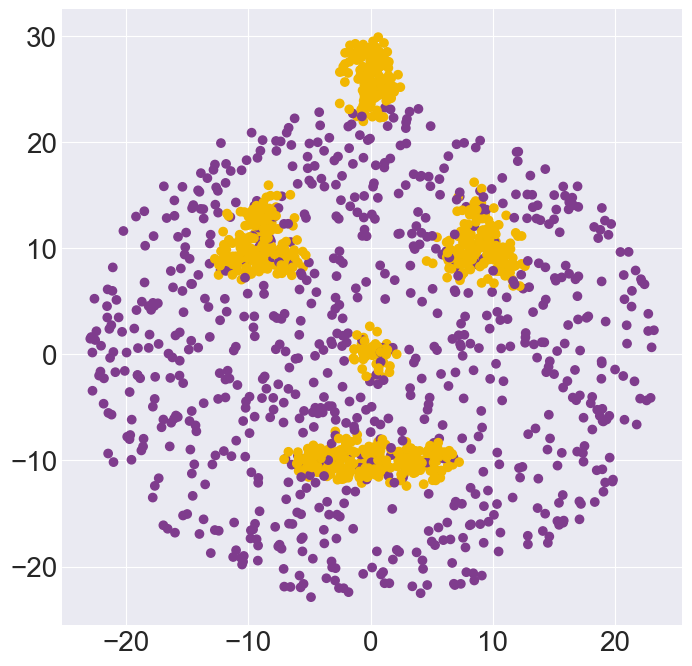

In [56]:
fig, ax = plt.subplots(figsize = (8,8))
ax.scatter(rbf_dev_train[:,0],rbf_dev_train[:,1], c = y_train, cmap = cartocolors.qualitative.Bold_4.mpl_colormap )
plt.show()

## Task 2: Radial basis function neural network

In [49]:
from rbf_net import RBF_Net

### 2a. Network initalization

You will use K-means to initialize the RBF hidden layer prototypes and sigmas.

1. Copy over your `kmeans.py` from your previous project. If your K-means clustering code isn't working properly, you may use `scipy` functions in this project instead, but at a 1 point reduction. Check out `scipy.cluster.vq.kmeans`.

2. Implement the method templates in `rbf.py` that initialize the hidden layer of the neural network:
    - Finish writing the constructor
    - `get_num_hidden_units`
    - `get_num_output_units`
    - `avg_cluster_dist`: Compute the average distance between each cluster center found by K-means and all the points assigned to the same cluster.
    - `initialize`: Use K-means to set the Gaussian hidden unit centers (**prototypes**) and standard deviations (**sigmas**).


In [50]:
from kmeans import KMeans

#### Test `avg_cluster_dist`

In [51]:
np.random.seed(0)

# N = 10 samples, M = 5 features
test_data = np.random.normal(size=(10, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_assignments = np.random.randint(low=0, high=4, size=(10,))
kmeansObj = KMeans()

test_net = RBF_Net(4, 3)
print(f'Number of hidden units in your net is {test_net.get_num_hidden_units()} and should be 4')
print(f'Number of output units in your net is {test_net.get_num_output_units()} and should be 3')
test_clust_mean_dists = test_net.avg_cluster_dist(test_data, test_centroids, test_assignments, kmeansObj)

print(f'Your avg within cluster distances are\n{test_clust_mean_dists} and should be\n[2.23811 3.94891 3.12267 3.4321]')

Number of hidden units in your net is 4 and should be 4
Number of output units in your net is 3 and should be 3
Your avg within cluster distances are
[2.23811 3.94891 3.12267 3.4321 ] and should be
[2.23811 3.94891 3.12267 3.4321]


#### Test `initialize`

In [52]:
test_net.initialize(test_data)

print(f'Your prototypes have shape {test_net.get_prototypes().shape} and the shape should be (4, 5).')
print(f'Your hidden unit sigmas have shape {test_net.sigmas.shape} and the shape should be (4,).')

Your prototypes have shape (4, 5) and the shape should be (4, 5).
Your hidden unit sigmas have shape (4,) and the shape should be (4,).


#### Test initialization methods

In the cell below, write test code for your RBF network initialization:
- Create a new RBF network with 7 hidden units and 2 output classes.
- Call the `initalize` method on it, passing in the training data.
- Create a class color-coded scatterplot of the training data with an equal axis aspect ratio, like above, now with the prototypes clearly marked with a different marker and/or color.

You should see fairly evenly distributed prototypes, with one in most, if not all, "pockets" of samples belonging to a single class.

In [53]:
# Keep me
np.random.seed(0)

# Create your network here
test_rbf = RBF_Net(7, 2)
test_rbf.initialize(data = rbf_dev_train)

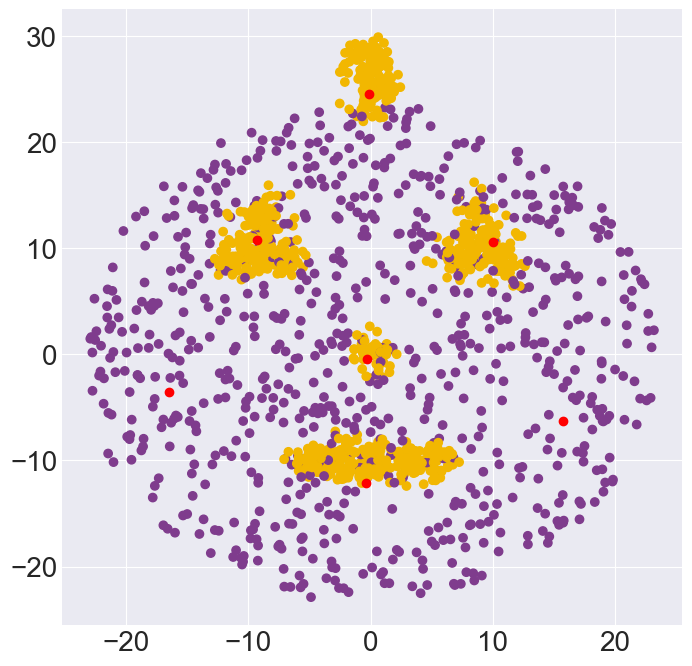

In [60]:
# Your plot here
fig, ax = plt.subplots(figsize = (8,8))
#plot the figure
ax.scatter(rbf_dev_train[:,0],rbf_dev_train[:,1], c = y_train, cmap = cartocolors.qualitative.Bold_4.mpl_colormap)
prototypes = test_rbf.get_prototypes()
#plot the prototypes
for i in range(prototypes.shape[0]):
    ax.scatter(prototypes[i][0], prototypes[i][1], c= "red")

plt.show()

**Question 1:** Do you think the prototypes enable the RBF network to learn the data well? Why or why not?

**Answer 1:** 
I think the prototypes does enable the RBF network to learn the data well. As pointed by the graph, each prototype is the centroid of a group of samples that belong to a single class. Therefore, generating prototypes help RBF learn about the distinctions in classes too. 

### 2b. Compute hidden and output layer activations

Implement the following methods so that you can train your RBF network:
- `hidden_act`: Computes hidden layer activation values: Determines the similarity between hidden layer prototypes with the input data.
- `output_act`: Computes output layer activation values: Multiply hidden unit activation by output unit weights.

**Hidden unit activation**:

The activation of hidden unit $j$ to data sample $i$ is computed according to $$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2\sigma_j^2 + \epsilon}\right )$$ 
where $\vec{x_i}$ is the data sample, $\vec{c_j}$ is the prototype (center) of the hidden unit, $\sigma_j$ is the hidden unit's standard deviation, $\epsilon$ is a small number (e.g. 1e-8), and $dist(\cdot, \cdot)^2$ is the **squared** Euclidean distance.

#### Test hidden_act

In [ ]:
np.random.seed(1)

# N = 3 samples, M = 5 features
test_data = np.random.normal(size=(3, 5))
# 4 hidden units / prototypes, each has 5 features
test_centroids = np.random.normal(size=(4, 5))
# Each sample assigned to one of 4 hidden unit prototypes
test_sigmas = np.random.uniform(size=(4,))
test_wts = 2*np.random.uniform(size=(4+1, 3)) - 1

test_net = RBF_Net(4, 3)
test_net.prototypes = test_centroids
test_net.sigmas = test_sigmas
test_net.wts = test_wts
test_h_act = test_net.hidden_act(test_data)
print(f'Your hidden layer activation is\n{test_h_act}\n\nand should be')
print('[[0.      0.      0.00009 0.00033]\n [0.00013 0.      0.00004 0.00014]\n [0.      0.      0.      0.00001]]')

Your hidden layer activation is
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]

and should be
[[0.      0.      0.00009 0.00033]
 [0.00013 0.      0.00004 0.00014]
 [0.      0.      0.      0.00001]]


#### Test output_act

In [ ]:
test_out_act = test_net.output_act(test_h_act)
print(f'Your output layer activation is\n{test_out_act}\n\nand should be')
print('[[-0.72136  0.61505 -0.20481]\n [-0.72151  0.61487 -0.20466]\n [-0.72144  0.61479 -0.20465]]')

Your output layer activation is
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]

and should be
[[-0.72136  0.61505 -0.20481]
 [-0.72151  0.61487 -0.20466]
 [-0.72144  0.61479 -0.20465]]


### 2c. Learn network weights using linear regression

To train your RBF network, you will need to find optimal weights between hidden and output layer neurons to allows your network to accurately classify the training data (i.e. learn from the data). An efficient solution is to use linear regression to solve a least square problem: minimizing the squared difference between the *hidden layer activations* and the *true data classes*.

In `rbf.py`, implement `linear_regression(A, y)`. To do this, adapt your code in `linear_regression` to use your QR solver.

#### Test linear regression

Running the following test code should generate a familar regression fit to the Iris data.

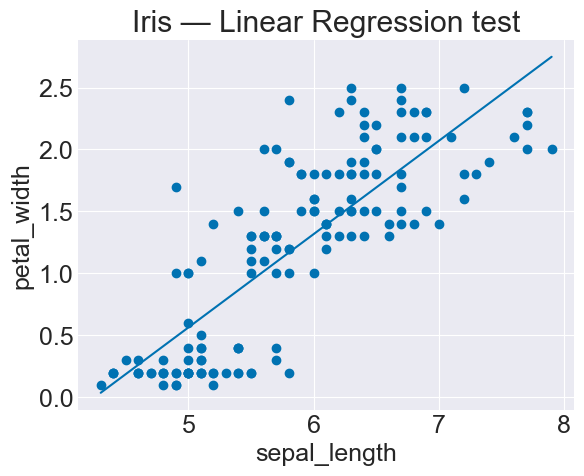

In [ ]:
df = pd.read_csv('data/iris.csv')
iris = df[['sepal_length', 'petal_width']].to_numpy()

num_hidden_units = 1
num_classes = 4
net = RBF_Net(num_classes=num_classes, num_hidden_units=num_hidden_units)
iris_x = np.reshape(iris[:, 0], [len(iris), 1])
iris_y = np.reshape(iris[:, 1], [len(iris), 1])
iris_c = net.linear_regression(iris_x, iris_y)

line_x = np.linspace(iris_x.min(), iris_x.max())
line_y = line_x * iris_c[0] + iris_c[1]
plt.scatter(iris_x, iris_y)
plt.plot(line_x, line_y)
plt.title('Iris — Linear Regression test')
plt.xlabel('sepal_length')
plt.ylabel('petal_width')
plt.show()

### 2d. Train your RBF Network

Implement the following methods then train your neural network! In the cell below, train a RBF network with 10 hidden units on the RBF dev dataset. **If everything is working, you should get >=88% accuracy on the training set and >=89% on the test set.**

- `train`: Determine the optimal output layer weights that fit hidden layer activation using linear regression.
- `predict`: Use trained network (after learning) to predict the class of data.
- `accuracy`: Compute the accuracy by comparing the network predicted and actual class for each data sample.



In [ ]:
#test 
rbf_test_train = RBF_Net(num_hidden_units=10, num_classes=2)
rbf_test_train.train(rbf_dev_train, y_train)
train_ypred = rbf_test_train.predict(rbf_dev_train)

In [ ]:
# Training set accuracy
train_acc = rbf_test_train.accuracy(train_ypred, y_train)
print(train_acc)

0.888125


In [ ]:
# Test set accuracy
rbf_test_test = RBF_Net(num_hidden_units=10, num_classes=2)
rbf_test_test.train(rbf_dev_test, y_test)
test_ypred = rbf_test_test.predict(rbf_dev_test)
test_acc = rbf_test_train.accuracy(test_ypred, y_test)
print(test_acc)

0.895


## Task 3: Handwritten digit classification: MNIST data

You will train a RBF network on a "real" image dataset of handwritten number digits:
- 60,000 images in training set, 10,000 images in test set.
- Each image is 28x28 pixels.
- The images are grayscale (no RGB colors).
- Each image (data sample) contains ONE of 10 numeric digit $0, 1, 2, \ldots, 8, 9$.

The goal is to train your network so that it can correctly predict the numeric digit in an image.

More information about MNIST: http://yann.lecun.com/exdb/mnist/

### 3a. Load in and look at MNIST dataset

- Use the numpy function `load` to load in the MNIST train/test data and the associated class labels.
- Create a 5x5 grid showing the first 25 images in the dataset. It should "look good" (e.g. turn off tick marks).

In [ ]:
# Load data here
x_train = np.load("data/mnist_train_data.npy")
y_train = np.load("data/mnist_train_labels.npy")

x_test = np.load("data/mnist_test_data.npy")
y_test = np.load("data/mnist_test_labels.npy")


In [ ]:
print(f'Your training set shape is {x_train.shape} and should be (60000, 28, 28).')
print(f'Your training classes shape is {y_train.shape} and should be (60000,).')
print(f'Your test set shape is {x_test.shape} and should be (10000, 28, 28).')
print(f'Your test classes shape is {y_test.shape} and should be (10000,).')

Your training set shape is (60000, 28, 28) and should be (60000, 28, 28).
Your training classes shape is (60000,) and should be (60000,).
Your test set shape is (10000, 28, 28) and should be (10000, 28, 28).
Your test classes shape is (10000,) and should be (10000,).


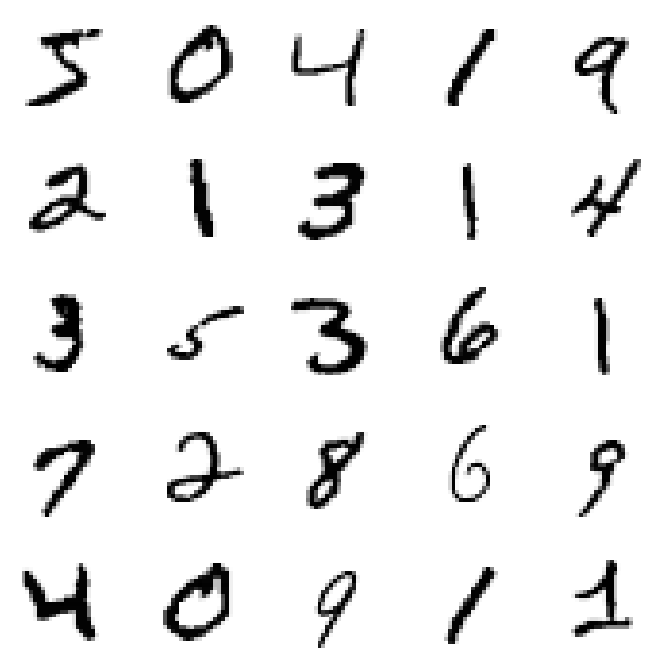

In [ ]:
# 5x5 plot here
fig, axes = plt.subplots(5,5,figsize = (7,7))
for i, a in enumerate(axes.reshape(-1)):
    a.imshow(X = x_train[i])
    a.axis("off")
fig.tight_layout()

### 3b. Preprocess data

- Flatten non-leading dimensions of the train and test sets. For example, the training set should go from (60000, 28, 28) to (60000, 784). **Do not hard code this!** Your code should work for any data with three dimensions.
- Normalize so that the maximum possible value in each image is 1 (and the minimum possible is 0) by dividing by 255.

In [ ]:
def flatten(matrix2d): 
    return matrix2d.reshape((matrix2d.shape[0],matrix2d.shape[1] * matrix2d.shape[1]))

flat_x_train = flatten(x_train)/255
flat_x_test = flatten(x_test)/255

print(flat_x_train.shape)
print(flat_x_test.shape)

(60000, 784)
(10000, 784)


### 3c. Train and assess performance on MNIST

Train a RBF network on MNIST. **Your goal is to get >=90% accuracy on both train and test sets.**

**Tips:**
- Depending on your laptop or machine you are using, training could take many hours if you use the full 60,000 sample training set. Select a subset to train on (e.g. ~1500) that takes a reasonable amount of time (e.g. minutes). You should be able to hit your accuracy goals without too much data, effort, or time.
- Do not pare down the test set (i.e. it should remain at 10,000 samples).
- Use the code below to visualize your hidden layer prototypes to help with debugging (assumes your network is called `mnist_net`). Your prototypes should look like images of certain digits, perhaps a little blurrier.

In [ ]:
# train acc
mnist_net = RBF_Net(num_hidden_units=100, num_classes=10)
mnist_net.train(flat_x_train[:1500,:], y_train[:1500])
train_ypred = mnist_net.predict(flat_x_train[:1500,:])
train_acc = mnist_net.accuracy(train_ypred, y_train[:1500])
print(f"train_acc: {train_acc}")

train_acc: 0.9193333333333333


In [ ]:
# test acc
mnist_net.train(flat_x_test, y_test)
test_ypred = mnist_net.predict(flat_x_test)
test_acc = mnist_net.accuracy(test_ypred, y_test)
print(f"Test accuracy: {test_acc}" )

Test accuracy: 0.9231


(100, 28, 28)


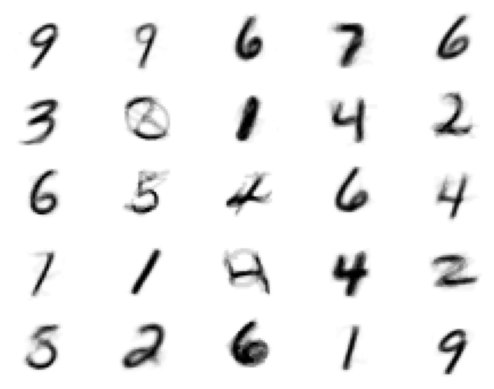

In [ ]:
# Visualize network hidden layer prototypes
prototypes = mnist_net.get_prototypes()
prototypes = np.reshape(prototypes, [prototypes.shape[0], 28, 28])
print(prototypes.shape)

cols = rows = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i in range(rows):
    for j in range(cols):
        axes[i, j].imshow(prototypes[i*rows + j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

**Question 2:** Which part of the training process takes the longest?

**Answer 2:** 
Training on the test data takes a lot of time because of the large data. In the train method, running linear regression on each output unit definitely takes the longest time. 

**Question 3:** What accuracy did you achieve on the training set? List all parameters that you needed to set (e.g. number of training samples, number hidden units, etc).

**Answer 3:**
I got 0.91 training accuracy with 1500 samples, 100 hidden units

**Question 4:** Using the same parameters to get the training accuracy that you reported in Question 3, what test accuracy did you achieve?

**Answer 4:**
I got 0.90 accuracy (demonstrated below)

In [ ]:
mnist_net.train(flat_x_test[:1500,:], y_test[:1500])
test_ypred = mnist_net.predict(flat_x_test[:1500,:])
test_acc = mnist_net.accuracy(test_ypred, y_test[:1500])
print(f"Test accuracy: {test_acc}" )

Test accuracy: 0.904


### 3d. Visualize prototypes using network weights

Now that you've trained the network to recognize handwritten digits, let's visualize the dominant factors that the network learns to rely on to make each prediction.

Create a 10 x 5 plot showing images of the 5 "most influential hidden layer prototypes" that contribute to predicting each of the 10 output classes. These are defined as the hidden layer prototypes that have the 5 largest weights going from the hidden layer to the output layer. *Recall that each hidden unit prototype has the same shape as a single data sample so each image in your grid should be 28x28.*

In [ ]:
#each row is a class (output unit)
#loop through each column of self.wts, 
#find the indices of 5 greatest weights 
prototypes = mnist_net.get_prototypes()
weights = mnist_net.get_weights()
num_classes = mnist_net.get_num_output_units()

most_infl_prototypes = np.zeros((10, 5, 784))

for i in range(num_classes): 
    weight_col = weights[:,i]
    most_infl_indices = np.argsort(weight_col)[::-1][:5]
    most_infl_prototypes[i] = prototypes[most_infl_indices] 

most_infl_prototypes = most_infl_prototypes.reshape((50,28,28))
#loop thru self.prototyes, retrieve the prototypes that belong to each indices

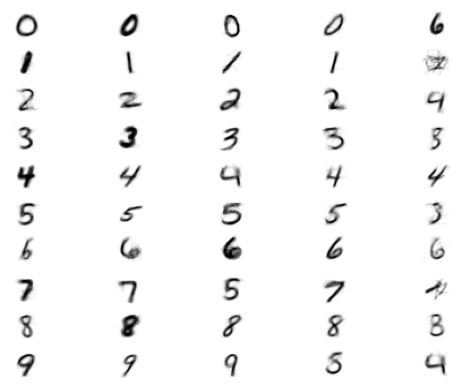

In [ ]:
rows = 10 
cols = 5
fig, axes = plt.subplots(nrows=rows, ncols=cols)
for i, a in enumerate(axes.reshape(-1)):
    a.imshow(X = most_infl_prototypes[i])
    a.axis("off")

**Question 5:** Interpret what each row of your 10x5 grid of images means. Did any of the top prototypes surprise you?

**Answer 5:** 
Each row in my grid represents the prototypes that have the heighest weight in determining the final classificiation of the input variables. In other words, these prototypes might have the closest distances to the input variable (so highest hidden activation), so they are the most dominant factors that the networks use to classify the variables. Most of them don't surprise me, but it's interesting in the last row (for 9) there are a prototype that looks like a 4 and another one that looks more lik an 8, and the row for 1 also have a prototype that is just a messy number. The row for 7 also have a 5 in there, which means that the network are pretty tolerable for prototypes that are far from the input variable, due to the high sigma.

## Task 4: RBF neural networks for regression

In this task you will make modest changes and configure your RBF neural network to enable it to perform regression rather than solve classification problems.

### Task 4a. Plot regression curve data

Download and load in the regression "x values" (`'rbf_regression_x.npy'`) and "y values" (`'rbf_regression_y.npy'`). Create a plot of the curve that you on which will perform regression.

In [5]:
x_reg = np.load("data/rbf_regression_x.npy")
y_reg = np.load("data/rbf_regression_y.npy")
print(f"regression x shape: {x_reg.shape}")
print(f"regression y shape: {y_reg.shape}")

regression x shape: (150, 1)
regression y shape: (150, 1)


### 4b. Implement a RBF Neural Network for Regression 

Implement the methods in the `RBF_Reg_Net` class. In every case except the constructor, this involves copy-pasting code from your classification network and making small changes.

Note that the hidden unit variance gain parameter ($g$) modifies the RBF function as follows:

$$H_{ij} = \exp \left (-\frac{\text{dist} \left (\vec{x}_i, \vec{c}_j \right )^2}{2g*\sigma_j^2 + \epsilon}\right )$$

#### Test: RBF regression neural network

- Create an object of the `RBF_Reg_Net` network. Configure it with:
    - 1 output neuron
    - 50 hidden units
    - the default value for the hidden unit variance gain.
- Train the network and have it predict y values at the training x values.
- Plot the original (x, y) values on the curve, and along with the predicted y values at the same x values.

**If everything is working, the regression performed by your network should produce an almost "perfect" reconstruction of the original data curve.**

In [3]:
from rbf_net import RBF_Reg_Net

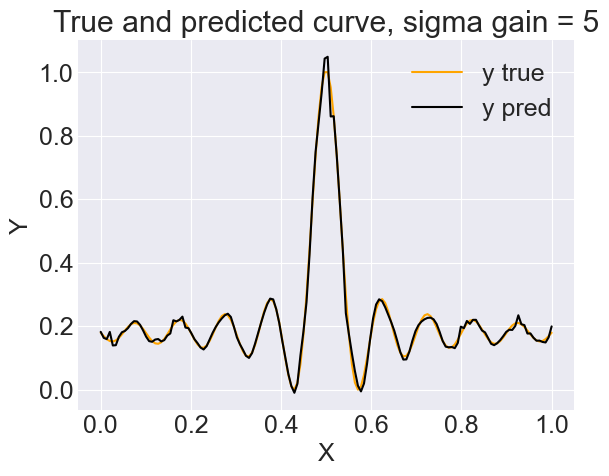

In [9]:
rbf_reg  = RBF_Reg_Net(num_hidden_units=50, num_classes=1, h_sigma_gain=5)
rbf_reg.train(x_reg, y_reg)
y_reg_pred = rbf_reg.predict(x_reg)
plt.plot(x_reg, y_reg, "orange", label = "y true")
plt.plot(x_reg, y_reg_pred, "black", label = "y pred")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("True and predicted curve, sigma gain = 5")
plt.legend()
plt.show()

### 4c. Analysis of RBF Regression Neural Network

**Question 6:** Below, train the RBF regression network again, but with the hidden unit variance gain set to 1 .Superimpose the predicted regression curve with the original curve in the same plot. What happens and why?

**Answer 6:** 
The general shape of the predicted curve still follows the general shape of the true curve. However, there are a lot of small fluctuations along the way. This is because without the variance gain, the width of the RBF curve returned by K means alone is too narrow, resulting in narrow small curves as shown in the plot.

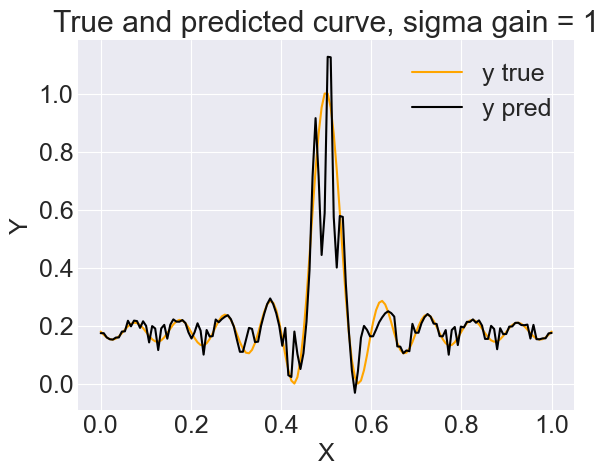

In [10]:
rbf_reg  = RBF_Reg_Net(num_hidden_units=50, num_classes=1, h_sigma_gain=1)
rbf_reg.train(x_reg, y_reg)
y_reg_pred = rbf_reg.predict(x_reg)
plt.plot(x_reg, y_reg, "orange", label = "y true")
plt.plot(x_reg, y_reg_pred, "black", label = "y pred")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("True and predicted curve, sigma gain = 1")
plt.legend()
plt.show()

**Question 7:** Run an experiment where you fix the hidden unit variance gain parameter to 5 and vary the number of hidden units in the network between 5 and 50. Create a plot showing the MSSE of the predictions vs the original data for each networks with a different number of hidden units. Explain what the plot reveals about the number of hidden units in the network.

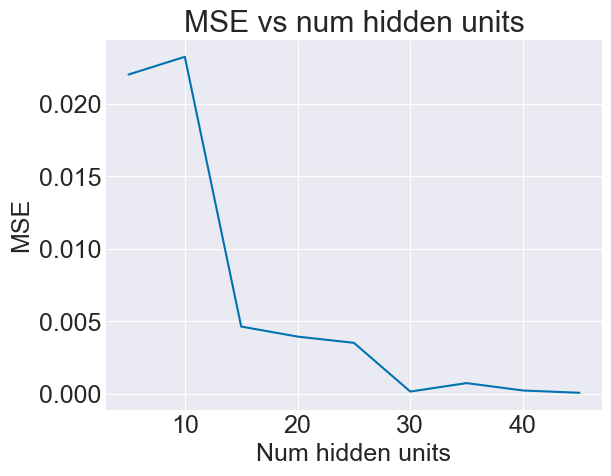

In [11]:
num_samples = x_reg.shape[0]
mses = []
num_hidden_units = []
for i in range(5,50, 5): 
    rbf_reg  = RBF_Reg_Net(num_hidden_units= i, num_classes=1, h_sigma_gain=5)
    rbf_reg.train(x_reg, y_reg)
    y_reg_pred = rbf_reg.predict(x_reg)
    mse =np.sum(np.square(y_reg_pred - y_reg))/num_samples
    mses.append(mse)
    num_hidden_units.append(i)

plt.plot(num_hidden_units, mses)
plt.xlabel("Num hidden units")
plt.ylabel("MSE")
plt.title("MSE vs num hidden units")
plt.show()

**Answer 7:** 
As we can see from the plot, MSE decreases significantly as number of hidden units increases. This is because the more hidden units (prototypes) we have, the more the network could learn from and therefore produce better result. For this model, it seems like 35 - 40 is a good enough number of hidden units, as MSE drops to near 0 at that point. However, the plot fluctuates a lot even at the range of 35-40, so it's safest to put n_hidden_unit = 50 to guarantee minimal MSE all the time.

**Question 8:** Run an experiment where you fix the number of hidden units to 10 and vary the hidden unit variance gain parameter between 2 and 50. Create a plot showing the MSSE of the predictions vs the original data for each networks with a different gain parameter value. Explain what the plot reveals about the hidden unit variance in the network.

**Answer 8:**
There is a lot more variation in this graph (MSE vs Hidden unit variance gain) compared to last graph (MSE vs Number of hidden units). This is because determining g is not as straightforward as determining k, which is the more the better. Because g is used to scale data, g can't be too small (or else scale is too narrow), and g also can't too big (or else scale is too wide). Therefore, the MSE seems to be larger in the the two ends of tried values of g (more than 0.024), and is lower in the middle between 5 to 20 (less than 0.024). Therefore, these g values are good for training data. 

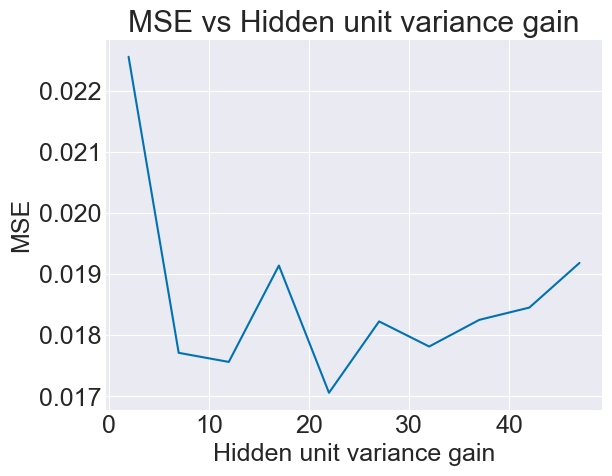

In [17]:
num_samples = x_reg.shape[0]
mses = []
h_sigma_gains = []
for i in range(2,50, 5): 
    rbf_reg  = RBF_Reg_Net(num_hidden_units= 10, num_classes=1, h_sigma_gain=i)
    rbf_reg.train(x_reg, y_reg)
    y_reg_pred = rbf_reg.predict(x_reg)
    mse =np.sum(np.square(y_reg_pred - y_reg))/num_samples
    mses.append(mse)
    h_sigma_gains.append(i)

plt.plot(h_sigma_gains, mses)
plt.xlabel("Hidden unit variance gain")
plt.ylabel("MSE")
plt.title("MSE vs Hidden unit variance gain")
plt.show()

## Extensions

To receive credit for any extension, you must:
- Not modify / prevent any code from the core project from working (e.g. make a copy before changing). In other words, **the notebook test code should still work!**
- **You must describe what you did and what you found in detail**. This includes a summary of parameter values used in your simulations.
- Include (*labeled!*) plots and/or numbers to present your results.
- Write up your extensions below or in a separate notebook.

**Rule of thumb: one deep, thorough extension is worth more than several quick, shallow extensions!**

### 1) Improve performance on MNIST with PCA

Using all 768 features (pixels) in each image may not be very helpful for classification. For example, pixels around the border are almost always white. Transform the dataset(s) using PCA to compress the number of features before training your RBF network. Experiment with PCA to improve classification accuracy and runtime performance.

MNIST data shape:  (1500, 784)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


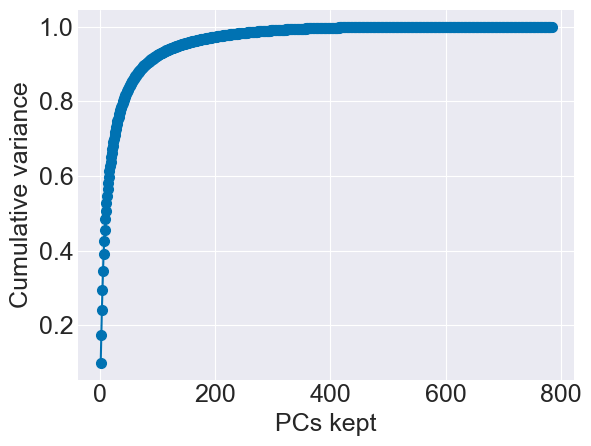

In [ ]:
from pca_cov import PCA_COV

#load data and run PCA
mnist_x = pd.DataFrame(flat_x_train[:1500,:])
print("MNIST data shape: ", mnist_x.shape)
pca_mnist = PCA_COV(mnist_x)
pca_mnist.pca(mnist_x.columns)

#Run elbow plot to determine top PCs to keep 
pca_mnist.elbow_plot()
plt.show()

Based on the plot, it looks like we only need to keep about 200/784 PCs to retain about 99% of information. Therefore, I would keep 200 dimensions only and compare the performance of RBF on the old and reduced dimension data. 

In [ ]:
import time
#project mnist into top 200 PCs
reduced_mnist_x = pca_mnist.pca_project([i for i in range(200)])
mnist_x = flat_x_train[:1500,:]
mnist_y = y_train[:1500]

#make a new RBF net object to compare performace of full versus reduced dataset
mnist_net = RBF_Net(num_hidden_units=100, num_classes=10)

print("old train x data", mnist_x.shape)
print("reduced train x data", reduced_mnist_x.shape)

old train x data (1500, 784)
reduced train x data (1500, 200)


In [ ]:
#reduced dimension timing and accuracy
start= time.time()
mnist_net.train(reduced_mnist_x, mnist_y)
train_ypred_reduced = mnist_net.predict(reduced_mnist_x)
end= time.time()

train_acc_reduced = mnist_net.accuracy(train_ypred_reduced, mnist_y)
print(f"train accuracy reduced dimension: {train_acc_reduced}")
print(f"train time reduced dimension: {end - start} seconds")

train accuracy reduced dimension: 0.9206666666666666
train time reduced dimension: 9.777845859527588 seconds


In [ ]:
#full dimension timing and accuracy

start= time.time()
mnist_net.train(mnist_x, mnist_y)
train_ypred_full = mnist_net.predict(mnist_x)
end= time.time()

train_acc_full = mnist_net.accuracy(train_ypred_full, mnist_y)
print(f"train accuracy full dimension: {train_acc_full}")
print(f"train time full dimension: {end - start} seconds")

train accuracy full dimension: 0.9126666666666666
train time full dimension: 14.831796884536743 seconds


MNIST test data shape:  (10000, 784)


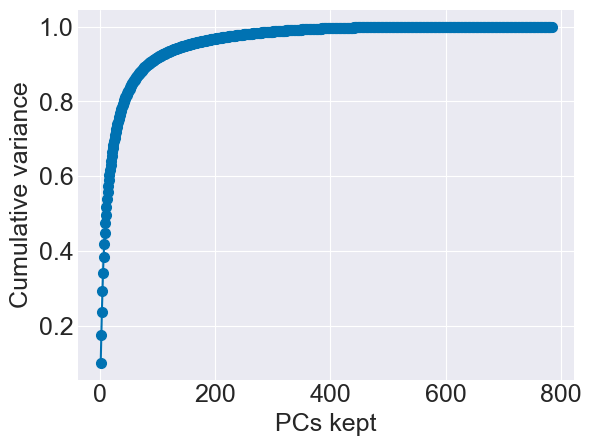

In [ ]:
#Now let's try the same thing on the test dataset
#As this is a bigger dataset, the difference in time performace would be more clear

mnist_x_test = pd.DataFrame(flat_x_test)
print("MNIST test data shape: ", mnist_x_test.shape)
pca_mnist_test = PCA_COV(mnist_x_test)
pca_mnist_test.pca(mnist_x_test.columns)
pca_mnist_test.elbow_plot()
plt.show()

It's not the surprising that train and test set have the same elbow plot, as variables are of the same kind (numbers digits are centered in the middle pixels of the image, of similar shape and size). Like before, I would choose to keep 200 PCs.

In [ ]:
#project mnist test into top 200 PCs

reduced_mnist_x_test = pca_mnist_test.pca_project([i for i in range(200)])

print("old test x data", flat_x_test.shape)
print("reduced test x data", reduced_mnist_x_test.shape)

old test x data (10000, 784)
reduced test x data (10000, 200)


In [ ]:
#reduced dimension timing and accuracy (test)
start= time.time()
mnist_net.train(reduced_mnist_x_test, y_test)
test_ypred_reduced = mnist_net.predict(reduced_mnist_x_test)
end= time.time()

test_acc_reduced = mnist_net.accuracy(test_ypred_reduced, y_test)
print(f"train accuracy reduced dimension: {test_acc_reduced}")
print(f"train time reduced dimension: {end - start} seconds")

train accuracy reduced dimension: 0.9238
train time reduced dimension: 192.12672591209412 seconds


In [ ]:
#full dimension timing and accuracy (test)
start= time.time()
mnist_net.train(flat_x_test, y_test)
test_ypred_full = mnist_net.predict(flat_x_test)
end= time.time()

test_acc_full = mnist_net.accuracy(test_ypred_full, y_test)
print(f"train accuracy full dimension: {test_acc_full}")
print(f"train time full dimension: {end - start} seconds")

train accuracy full dimension: 0.9241
train time full dimension: 189.86579298973083 seconds


As demonstrated above, the PCA significantly reduce the training time of the network because the dimensions is reduced to only 200 PCs that retain the most information. The accuracy is roughly the same to training on the full dimension data, which is amazing consider the time saved.

### 4) Initialization schemes

Research, test out, and quantify the performance of different techniques to set the hidden unit prototypes and sigmas. For example, an alternative way to initialize the prototypes is to perform K-means to cluster each class *separately*. 

In [ ]:
mnist_net.train(mnist_x, mnist_y)
train_ypred_norm = mnist_net.predict(mnist_x)
train_acc = mnist_net.accuracy(train_ypred, mnist_y)
print(f"train_acc: {train_acc}")

train_acc: 0.9106666666666666


In [ ]:
mnist_net.train(mnist_x, mnist_y, method="separate")
train_ypred_sep = mnist_net.predict(mnist_x)
train_acc_sep = mnist_net.accuracy(train_ypred_sep, mnist_y)
print(f"train_acc separate: {train_acc_sep}")

train_acc separate: 0.9573333333333334


For this extension, I implemented the separate initialization technique, which would extract data from each class separately and get centroids among those data. The number of centroids/ prototypes to make for each class relies on the proportion of each class in the dataset. I added a parameter "method" to training with a defaul value "common", which would initalize data normally. If the user specifies "seperate", however, the network would apply the separate initalization method.



We can see that from running the result of using different methods that the separate method yields a higher accuracy by about almost 5%. This might be because initialize separately guarantees that each class has enough prototypes to rely on, and reduce the chance of picking bad inital random centroids. Because the number of prototypes for each class is also based on the proportion of the class itself, each class is guaranteed to have enough protoypes to represent them. For example, if there are 600/700 samples of are of class 0, we want to make sure that class 0 have more prototypes than class 1 because there are more variables of class 0, so more differences and variations needs to be taken into account. This, in result, returns a higher accuracy rate. However, the runtime might increase. 

Acknowledgement: Yela 